# Preparation

Import tools

In [1]:
import pandas as pd                               # basic data tools
import numpy as np
from sklearn.preprocessing import LabelEncoder    # reprocessing tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV  # model selection
from sklearn import model_selection
from sklearn import metrics
import joblib                                     # model saving
import datetime
import lightgbm as lgbm                           # Models: # # LightGBM
from xgboost import XGBClassifier                           # # XGBoost
from sklearn.ensemble import RandomForestClassifier         # # Random Forest
import seaborn as sns                             # plotting
from matplotlib.pyplot import savefig

Accessing data:

In [2]:
# df = pd.read_csv('../data/hotel_bookings.csv') 
train = pd.read_csv('../data/train.csv') # pre-spllited dataset in previous work
test = pd.read_csv('../data/test.csv')

# Extra features spreadsheet for hepling understanding
features = pd.read_csv('../data/feature_description.csv', header=None)
features.columns = ['feature', 'description']

# Cleaning, Exploration and Basic Feature Engineering

Task alread done, see `part1.ipynb` if needed.

# Preparation

Check features:

In [3]:
# show features
pd.set_option("display.max_colwidth", 200)
pd.merge(features, train.describe().T, left_on='feature', right_index=True, how="right")

,feature,description,count,mean,std,min,25%,50%,75%,max
1,is_canceled,order canceled (1) or not (0),95512.0,0.370414,0.482918,0.00,0.0000,0.0,1.0,1.0
2,lead_time,Number of days that elapsed between the entering date of the booking into the PMS and the arrival date,95512.0,104.151583,106.821437,0.00,18.0000,69.0,160.0,737.0
5,arrival_date_week_number,Week number of year for arrival date,95512.0,27.171047,13.593740,1.00,16.0000,28.0,38.0,53.0
6,arrival_date_day_of_month,Day of arrival date,95512.0,15.797041,8.785365,1.00,8.0000,16.0,23.0,31.0
7,stays_in_weekend_nights,Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel,95512.0,0.927852,0.997446,0.00,0.0000,1.0,2.0,19.0
8,stays_in_week_nights,Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel,95512.0,2.500806,1.905649,0.00,1.0000,2.0,3.0,50.0
9,adults,Number of adults,95512.0,1.856866,0.594198,0.00,2.0000,2.0,2.0,55.0
10,children,Number of children,95512.0,0.104175,0.399210,0.00,0.0000,0.0,0.0,10.0
11,babies,Number of babies,95512.0,0.008020,0.094440,0.00,0.0000,0.0,0.0,9.0
16,is_repeated_guest,Value indicating if the booking name was from a repeated guest (1) or not (0),95512.0,0.031640,0.175041,0.00,0.0000,0.0,0.0,1.0


Use plain integer to encode categrical features according to [official documentation](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html) and explicit explanation in sector [Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html#categorical_feature).

## Preprocessing

Encoding categorical features:

In [4]:
categoricals = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
]

df = train.append(test) # construct a full dataframe for consistent encoding
df = df.fillna('0')
df['children'] = df['children'].astype(int) # type convertting
df_cat_tmp = df[categoricals].astype(str).apply(LabelEncoder().fit_transform) # encode cat columns
# df_encoded = pd.merge(df.drop(categoricals, axis=1), df_cat_tmp, left_index=True, right_index=True) # merge numeric and encoded cat columns
df[categoricals] = df_cat_tmp[categoricals].astype(int) # merge numeric and encoded cat columns
train_encoded = df.iloc[:len(train)]
test_encoded = df.iloc[len(train):]

Splitting encoded dataset:

In [5]:
target = 'is_canceled' # splitting features and target

X_train, X_test = train_encoded.drop(target, axis=1), test_encoded.drop(target, axis=1)
y_train, y_test = train_encoded[target], test_encoded[target]

Standarzation (note that categorical features ignored due to model requirements):

In [6]:
X_num_train, X_num_test = X_train.drop(categoricals, axis=1),  X_test.drop(categoricals, axis=1) # extracting numerical features

# scaling
scaler = StandardScaler()
scaler.fit(X_num_train)
scaled_features_train = scaler.transform(X_num_train)
scaled_features_test = scaler.transform(X_num_test)

# merge numeric & categorical features
scaled_features_df_train = pd.DataFrame(scaled_features_train, index=X_num_train.index, columns=X_num_train.columns)
scaled_features_df_test = pd.DataFrame(scaled_features_test, index=X_num_test.index, columns=X_num_test.columns)

# create standerized dataframes
X_train_std = pd.merge(X_train[categoricals], scaled_features_df_train, left_index=True, right_index=True)
X_test_std = pd.merge(X_test[categoricals], scaled_features_df_test, left_index=True, right_index=True)

# Modelling

Define a cutomized DridSearchCV function for convinience:

In [7]:
def algorithm_pipeline(model, \
                       param_grid, \
                       X_train_data = X_train_std, \
                       X_test_data = X_test_std, \
                       y_train_data = y_train, \
                       y_test_data = y_test, \
                       cv=10, \
                       scoring_fit='accuracy',
                       do_probabilities = False):
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        refit=True # return the best refitted model
    )
    
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      y_pred = fitted_model.predict_proba(X_test_data)
    else:
      y_pred = fitted_model.predict(X_test_data)
    
    return fitted_model, y_pred

In [ ]:
1. Log

## 2. LightGBM

A fast, distributed, high performance gradient boosting (GBT, GBDT, GBRT, GBM or MART) framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.  
  
[GitHub](https://github.com/microsoft/LightGBM) | [Documentation](https://lightgbm.readthedocs.io/en/latest/) | 
[Parameter Tuning (official tutorial)](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [33]:
# !pip install lightgbm # if not installed
lgbmclf = lgbm.LGBMClassifier()
param_grid = {
#     'objective':['binary','cross_entropy'],
    'objective':['binary'],
#     'boosting':['gbdt', 'dart'],
#     'boosting':['dart'],
    'n_estimators': [3000],
    'num_leaves': [25, 50, 100],
#     'min_data_in_leaf':[]
    'max_depth': [10, 25, 50],
#     'reg_alpha': [1.1, 1.3],
#     'reg_lambda': [1.1, 1.3],
    'lambda_l2': [0.1, 0.3, 0.5],
#     'min_split_gain': [0,  0.5],
    'feature_fraction': [0.3, 0.5, 0.7],
#     'subsample': [0.7, 0.9],
#     'subsample_freq': [20]
#     'max_bin': [100, 150]
}
gs, pred = algorithm_pipeline(lgbmclf, param_grid, cv=3) # some parameters already define above, see function algorithm_pipeline()
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 95.9min finished


0.8895426638415075
{'feature_fraction': 0.5, 'lambda_l2': 0.3, 'max_depth': 25, 'n_estimators': 3000, 'num_leaves': 50, 'objective': 'binary'}


Prediction and result:

Train(accuracy): 0.98999
Test(accuracy): 0.89505

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     15033
           1       0.87      0.84      0.86      8845

    accuracy                           0.90     23878
   macro avg       0.89      0.88      0.89     23878
weighted avg       0.89      0.90      0.89     23878



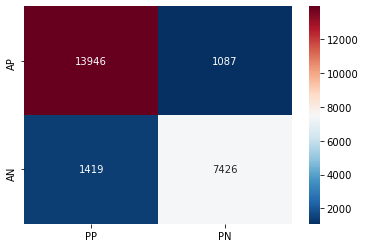

In [34]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Train(accuracy): {clf.score(X_train, y_train).round(5)}') # Python >= 3.7
print(f'Test(accuracy): {clf.score(X_test, y_test).round(5)}\n')
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

cm_matrix = pd.DataFrame(data=metrics.confusion_matrix(y_test, y_pred), columns=['PP', 'PN'], index=['AP', 'AN'])
cm_plot = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdBu_r') # visualize confusion matrix with seaborn heatmap
cm_plot

Dump the model to file for persistence:

In [35]:
now = datetime.datetime.now()
file_name = "../models/LightGBM_" + now.strftime("%m%d%H%M")

# save parameters
with open(f"{file_name}_{gs.best_score_.round(4)*100}%.txt", "w") as para_file:
    para_file.write(str(gs.best_params_))
    print(gs.best_params_)
    
# save figure
cm_plot.get_figure().savefig(file_name + ".png")

# save model
joblib.dump(clf, file_name + ".model")

# use this to load a saved model
# lgbm_loded = joblib.load('.model')

{'feature_fraction': 0.5, 'lambda_l2': 0.3, 'max_depth': 25, 'n_estimators': 3000, 'num_leaves': 50, 'objective': 'binary'}


['../models/LightGBM_04152334.model']

## 3. XGBoost

XGBoost - Extreme Gradient Boosting, which is an efficient implementation of the gradient boosting framework from Chen & Guestrin (2016) <doi:10.1145/2939672.2939785>.
  
[Github](https://github.com/dmlc/xgboost) | [Documentation](https://xgboost.readthedocs.io/en/latest/python/index.html) | 
[Parameter Tuning (official tutorial)](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)

Parameter tuning using GS

In [12]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,25],
#     'reg_alpha': [1.1, 1.3],
#     'reg_lambda': [1.1, 1.3],
#     'subsample': [0.7, 0.9],
#      'tree_method':['gpu_hist'],
#      'gpu_id':[1]
}
gs, pred = algorithm_pipeline(xgb, param_grid, cv=3)
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:   59.1s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished


0.8877523244002781
{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 100}


Prediction and result:

Train(accuracy): 0.99495
Test(accuracy): 0.89333

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     15033
           1       0.87      0.83      0.85      8845

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



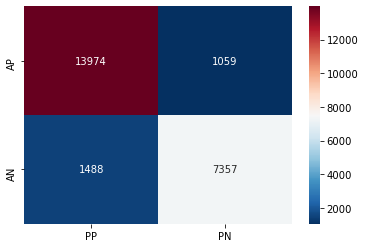

In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Train(accuracy): {clf.score(X_train, y_train).round(5)}') # Python >= 3.7
print(f'Test(accuracy): {clf.score(X_test, y_test).round(5)}\n')
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

cm_matrix = pd.DataFrame(data=metrics.confusion_matrix(y_test, y_pred), columns=['PP', 'PN'], index=['AP', 'AN'])
cm_plot = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdBu_r') # visualize confusion matrix with seaborn heatmap
cm_plot

Dumping to file:

In [14]:
now = datetime.datetime.now()
file_name = "../models/XGBoost_" + now.strftime("%m%d%H%M")

# save parameters
with open(f"{file_name}_{gs.best_score_.round(4)*100}%.txt", "w") as para_file:
    para_file.write(str(gs.best_params_))
    print(gs.best_params_)
    
# save figure
cm_plot.get_figure().savefig(file_name + ".png")

# save model
joblib.dump(clf, file_name + ".model")

# use this to load a saved model
# lgbm_loded = joblib.load('.model')

{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 100}


['../models/XGBoost_04152029.model']

## 4. Random Forest (🛑 no GS hitherto)

Fit the training set:

In [15]:
# feat_labels = X_train.columns
# X_train = X_train[feat_labels]
forest = RandomForestClassifier(n_estimators = 100, max_depth = 25, n_jobs = -1, 
                               random_state = 0, bootstrap = True)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Prediction and result:

Train(accuracy): 0.97796
Test(accuracy): 0.8925

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     15033
           1       0.89      0.81      0.85      8845

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



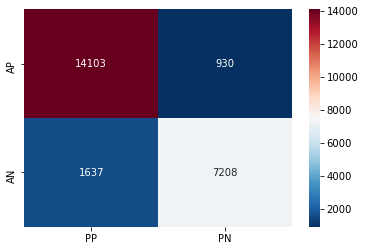

In [16]:
y_pred = forest.predict(X_test)
print(f'Train(accuracy): {forest.score(X_train, y_train).round(5)}')
print(f'Test(accuracy): {forest.score(X_test, y_test).round(5)}\n')
print(metrics.classification_report(y_test, y_pred))

cm_matrix = pd.DataFrame(data=metrics.confusion_matrix(y_test, y_pred), columns=['PP', 'PN'], index=['AP', 'AN'])
cm_plot = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdBu_r') # visualize confusion matrix with seaborn heatmap
cm_plot

Feature importance:

In [17]:
importances = forest.feature_importances_
feat_labels = X_train.columns
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
     print("%2d) %-*s %f" % (f + 1, 30, 
                             feat_labels[f], 
                             importances[indices[f]]))

 1) hotel                          0.146114
 2) lead_time                      0.120920
 3) arrival_date_month             0.115639
 4) arrival_date_week_number       0.068819
 5) arrival_date_day_of_month      0.062851
 6) stays_in_weekend_nights        0.059945
 7) stays_in_week_nights           0.046318
 8) adults                         0.045873
 9) children                       0.044790
10) babies                         0.035386
11) meal                           0.030336
12) country                        0.026822
13) market_segment                 0.026390
14) distribution_channel           0.025442
15) is_repeated_guest              0.024904
16) previous_cancellations         0.022886
17) previous_bookings_not_canceled 0.019146
18) reserved_room_type             0.014447
19) assigned_room_type             0.011666
20) booking_changes                0.011630
21) deposit_type                   0.010561
22) agent                          0.009580
23) company                     

Save:

In [18]:
clf = forest
now = datetime.datetime.now()
file_name = "../models/RandomForest_" + now.strftime("%m%d%H%M")

# save parameters
with open(f"{file_name}_{gs.best_score_.round(4)*100}%.txt", "w") as para_file:
    para_file.write(str(gs.best_params_))
    print(gs.best_params_)
    
# save figure
cm_plot.get_figure().savefig(file_name + ".png")

# save model
joblib.dump(clf, file_name + ".model")

# use this to load a saved model
# lgbm_loded = joblib.load('.model')

{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 100}


['../models/RandomForest_04152029.model']